**NOT** Removing observations that had more than 2 regions. Seeing what this says about the data. Using the non combined region regressors. 

In [1]:
options(jupyter.plot_mimetypes = "image/png")
library(nlme)
library(ggplot2)
library(corrplot)
library(gridExtra)
library(grid)
library(data.table)
library(effects)
library(xtable)
library(extrafont)
library(lsmeans)
library(multcomp)


## Load Data

In [2]:
data = read.csv("../data_meta_analysis/Data_Classifications_v8b.csv")

# change the resolution string 3mmx3mmx3mm->volumne 9mm^3
calc_resolution <-function(string){
    str_list<-strsplit(gsub('mm','',string),'x')[[1]] # 
    vol<-prod(as.integer(str_list))
    return(vol)
}

data$Resolution_Volume<-lapply(data$Resolution,calc_resolution)

In [3]:
data<-data[c('PID','Info.type','Accuracy.50','Significance','Roi.Search',
             'Pattern.type','Classifier.type','Scanner','Smoothing',
             'Coregistration','Pattern.normalization.type','Num_subs',
             'Resolution_Volume','Voxel.numbers','Training.setsize')]

factors<-c('Info.type','Significance','Roi.Search',
             'Pattern.type','Classifier.type','Scanner','Smoothing',
           'Coregistration','Pattern.normalization.type','Num_subs',
           'Resolution_Volume','Voxel.numbers','Training.setsize')

In [4]:
for (pid in unique(data$PID)){
    #print('--')
    #print(pid)
    #print(nrow(data1[data1$PID==pid,]))
    #print('--')
    data[data$PID==pid,'n_per_study']=nrow(data[data$PID==pid,])
}

In [5]:
# msc

R1 = read.csv(paste("../data_meta_analysis/data_derived_meta_analysis/X_region1_before_clustering_v8b.csv"))
#R2 = read.csv(paste("X_region1_after_clustering.csv"))
#R3 = read.csv(paste("../data_meta_analysis/data_derived_meta_analysis/X_region1_after_clustering_lr_2.csv"))
#R4 = read.csv(paste("../data_meta_analysis/data_derived_meta_analysis/X_region1_after_clustering2_2.csv"))
#R5 = read.csv(paste("../data_meta_analysis/data_derived_meta_analysis/X_region1_combined_regs_v8b.csv"))

R1names = colnames(R1)
#R2names = colnames(R2)
#R3names = colnames(R3)
#R4names = colnames(R4)
#R5names = colnames(R5)

# i=1
# for (name in R3names){
#     R3names[i]<-paste(sep='','R3',name)
#     i=i+1
# }
# R3names
# colnames(R3)<-R3names
# #head(R3)

In [6]:
#R5[18,]

In [7]:
#rowSums(R5)

In [8]:
data = cbind(data,R1) # will bind with other region names too 

In [9]:
nrow(data)

[1] 891

In [10]:
# mscl fixed 
data<-data[!data$Classifier.type=='neural-net',] # no observations but still has a level
data[data$Scanner=='4T','Scanner']='3T' # only one observatoin with 3T

data$PID<-as.factor(data$PID)
data$Info.type<-as.factor(data$Info.type)
data$Smoothing<-as.factor(data$Smoothing)
data$Roi.Search<-as.factor(data$Roi.Search)
data$Classifier.type<-as.factor(data$Classifier.type)
data$Coregistration<-as.factor(data$Coregistration)
data$Pattern.type<-as.factor(data$Pattern.type)
data$Pattern.normalization.type<-as.factor(data$Pattern.normalization.type)

data$Resolution_Volume<-as.numeric(data$Resolution_Volume)
data$Voxel.numbers<-as.numeric(data$Voxel.numbers)
data$Training.setsize<-as.numeric(data$Training.setsize)

In [11]:
data<-droplevels(data) # just drops unused levels 
nrow(data)

[1] 891

In [12]:
data_50<-subset(data,!is.na(Accuracy.50))
data_50_non<-subset(data,!is.na(Accuracy.50)& Significance==0)
data_50_sig<-subset(data,!is.na(Accuracy.50) & Significance==1)
head(data_50_sig)
nrow(data_50_sig)

,PID,Info.type,Accuracy.50,Significance,Roi.Search,Pattern.type,Classifier.type,Scanner,Smoothing,Coregistration,⋯,Frontal_Sup_Medial_L,Frontal_Sup_Medial_R,Insula_L,Insula_R,Cingulum_Ant_L,Cingulum_Ant_R,Cingulum_Mid_L,Cingulum_Mid_R,Precentral_L,Precentral_R
4,1,Perceptual,0.528,1,ROI,Multi-Trial Multi-Time Point,svm-lin,3T,unsmooth,Native Space,⋯,0,0,1,1,0,0,0,0,0,0
9,1,Rule,0.535,1,ROI,Multi-Trial Multi-Time Point,svm-lin,3T,unsmooth,Native Space,⋯,0,0,1,1,0,0,0,0,0,0
10,1,Rule,0.541,1,ROI,Multi-Trial Multi-Time Point,svm-lin,3T,unsmooth,Native Space,⋯,0,0,0,0,0,0,0,0,0,0
11,1,Rule,0.543,1,ROI,Multi-Trial Multi-Time Point,svm-lin,3T,unsmooth,Native Space,⋯,0,0,1,1,0,0,0,0,0,0
12,1,Rule,0.593,1,ROI,Multi-Trial Multi-Time Point,svm-lin,3T,unsmooth,Native Space,⋯,0,0,0,0,0,0,0,0,0,0
16,2,Rule,0.640,1,ROI,Single Trial Multi-Time Point,LDA,3T,unsmooth,Native Space,⋯,0,0,0,0,0,0,0,0,1,1


[1] 512

In [13]:
length(unique(data$PID))

[1] 76

## Mixed Effects, Sig, All Factors - more regions

In [14]:
# # remove some pairs of regions 
# # used in a later analysis
# R5names = R5names[R5names!='Cingulum_Mid_R']
# R5names = R5names[R5names!='Frontal_Mid_R.Frontal_Inf_Tri_L']
# R5names = R5names[R5names!='Frontal_Mid_L.Precentral_R']
# R5names = R5names[R5names!='Cingulum_Ant_R.Cingulum_Mid_R']
# R5names = R5names[R5names!='Frontal_Sup_R.Frontal_Sup_Medial_R  ']
# R5names = R5names[R5names!='Frontal_Sup_L.Frontal_Sup_Medial_L']
# R5names = R5names[R5names!='Frontal_Inf_Tri_R.Frontal_Inf_Orb_R']
# R5names = R5names[R5names!='Frontal_Sup_R.Frontal_Sup_Medial_R']
# R5names = R5names[R5names!='Frontal_Inf_Oper_R.Precentral_L']
# R5names = R5names[R5names!='Frontal_Inf_Oper_R.Precentral_R']
# R5names = R5names[R5names!='Frontal_Mid_R.Frontal_Inf_Tri_R']
# R5names = R5names[R5names!='Frontal_Inf_Oper_R.Frontal_Inf_Tri_R']


In [15]:
d<-data_50_sig[c('Accuracy.50','PID',factors,R1names)]

nrow(d)

[1] 512

In [16]:
nrow(unique(d['PID']))

[1] 75

**Indicator variables for missingness of continuous predictors.** A popular approach
in the social sciences is to include for each continuous predictor variable with missingness
an extra indicator identifying which observations on that variable have
missing data. Then the missing values in the partially observed predictor are replaced
by zeroes or by the mean (this choice is essentially irrelevant). This strategy
is prone to yield biased coefficient estimates for the other predictors included in the
model because it forces the slope to be the same across both missing-data groups.
Adding interactions between an indicator for response and these predictors can help
to alleviate this bias (this leads to estimates similar to complete-case estimates).Indicator variables for missingness of continuous predictors. A popular approach
in the social sciences is to include for each continuous predictor variable with missingness
an extra indicator identifying which observations on that variable have
missing data. Then the missing values in the partially observed predictor are replaced
by zeroes or by the mean (this choice is essentially irrelevant). This strategy
is prone to yield biased coefficient estimates for the other predictors included in the
model because it forces the slope to be the same across both missing-data groups.
Adding interactions between an indicator for response and these predictors can help
to alleviate this bias (this leads to estimates similar to complete-case estimates).

See http://www.stat.columbia.edu/~gelman/arm/missing.pdf

In [17]:
# replacing missing values with median and adding indicator variable
d['Voxel.numbers.idx'] = as.numeric(is.na(d['Voxel.numbers']))
d[is.na(d['Voxel.numbers']),'Voxel.numbers'] = median(d$Voxel.numbers,na.rm=TRUE)

d['Training.setsize.idx'] = as.numeric(is.na(d['Training.setsize']))
d[is.na(d['Training.setsize']),'Training.setsize'] = median(d$Training.setsize,na.rm=TRUE)




In [18]:
# # remove signficance from the data set 
factors<-c('Info.type','Roi.Search',
             'Pattern.type','Classifier.type','Scanner','Smoothing',
           'Coregistration','Pattern.normalization.type','Num_subs',
           'Resolution_Volume','Voxel.numbers','Training.setsize')

# factors<-c('Info.type','Roi.Search',
#              'Pattern.type','Classifier.type','Scanner','Smoothing',
#            'Coregistration','Pattern.normalization.type','Num_subs',
#            'Resolution_Volume')

In [19]:
R1names_string<-c()
r=1
for (R in R1names){
    # don't add last name - to prevent overparameterization. 
    if(r<length(R1names)){
    R1names_string<-paste(R1names_string,R,sep='+')
    }
    r<-r+1 
}
for (f in factors){
    R1names_string<-paste(R1names_string,f,sep='+')
    
}

R1names_string<-substring(R1names_string, 2)
R1names_string

[1] "Frontal_Sup_L+Frontal_Sup_R+Frontal_Sup_Orb_L+Frontal_Sup_Orb_R+Frontal_Mid_L+Frontal_Mid_R+Frontal_Mid_Orb_L+Frontal_Mid_Orb_R+Frontal_Inf_Oper_L+Frontal_Inf_Oper_R+Frontal_Inf_Tri_L+Frontal_Inf_Tri_R+Frontal_Inf_Orb_L+Frontal_Inf_Orb_R+Supp_Motor_Area_L+Supp_Motor_Area_R+Frontal_Sup_Medial_L+Frontal_Sup_Medial_R+Insula_L+Insula_R+Cingulum_Ant_L+Cingulum_Ant_R+Cingulum_Mid_L+Cingulum_Mid_R+Precentral_L+Info.type+Roi.Search+Pattern.type+Classifier.type+Scanner+Smoothing+Coregistration+Pattern.normalization.type+Num_subs+Resolution_Volume+Voxel.numbers+Training.setsize"

In [20]:
#R5names[37]

In [21]:
R1names

[1] "Frontal_Sup_L"        "Frontal_Sup_R"        "Frontal_Sup_Orb_L"   
 [4] "Frontal_Sup_Orb_R"    "Frontal_Mid_L"        "Frontal_Mid_R"       
 [7] "Frontal_Mid_Orb_L"    "Frontal_Mid_Orb_R"    "Frontal_Inf_Oper_L"  
[10] "Frontal_Inf_Oper_R"   "Frontal_Inf_Tri_L"    "Frontal_Inf_Tri_R"   
[13] "Frontal_Inf_Orb_L"    "Frontal_Inf_Orb_R"    "Supp_Motor_Area_L"   
[16] "Supp_Motor_Area_R"    "Frontal_Sup_Medial_L" "Frontal_Sup_Medial_R"
[19] "Insula_L"             "Insula_R"             "Cingulum_Ant_L"      
[22] "Cingulum_Ant_R"       "Cingulum_Mid_L"       "Cingulum_Mid_R"      
[25] "Precentral_L"         "Precentral_R"

In [22]:
#d$Voxel.numbers

# Coefficients

In [23]:
#colSums(d[R5names])


In [24]:
#sapply(d, class)
#d$PID

In [26]:
full_model<-lme(as.formula(paste('Accuracy.50~',R1names_string,sep='')),
                random=~1|PID,data=d,method='REML',na.action=na.omit)
summary(full_model)

Linear mixed-effects model fit by REML
 Data: d 
        AIC       BIC   logLik
  -1041.603 -838.6429 569.8014

Random effects:
 Formula: ~1 | PID
        (Intercept)   Residual
StdDev:  0.05915025 0.05232322

Fixed effects: as.formula(paste("Accuracy.50~", R1names_string, sep = "")) 
                                                     Value  Std.Error  DF
(Intercept)                                      0.7284639 0.07406036 404
Frontal_Sup_L                                   -0.0016515 0.01288293 404
Frontal_Sup_R                                    0.0101440 0.01200899 404
Frontal_Sup_Orb_L                                0.0217496 0.02761494 404
Frontal_Sup_Orb_R                                0.0043290 0.03058308 404
Frontal_Mid_L                                   -0.0039450 0.00887824 404
Frontal_Mid_R                                   -0.0074475 0.00917872 404
Frontal_Mid_Orb_L                               -0.0135098 0.02091530 404
Frontal_Mid_Orb_R                               

# Post-hoc Comparison of Coefficients 

# Post-hoc Comparison of Coefficients 

In [107]:
lsmeans(full_model,pairwise~Pattern.type,adjust='None')

$lsmeans
 Pattern.type                      lsmean         SE df  lower.CL  upper.CL
 Multi-Trial Multi-Time Point   0.6808757 0.03069262 54 0.6193407 0.7424107
 Multi-Trial Single-Time Point  0.6091079 0.03881999 54 0.5312785 0.6869373
 Single Trial Multi-Time Point  0.6386516 0.03198291 54 0.5745297 0.7027735
 Single Trial Single-Time Point 0.6438881 0.04046107 54 0.5627685 0.7250076

Results are averaged over the levels of: Info.type, Roi.Search, Classifier.type, Scanner, Smoothing, Coregistration, Pattern.normalization.type 
Confidence level used: 0.95 

$contrasts
 contrast                                                           estimate
 Multi-Trial Multi-Time Point - Multi-Trial Single-Time Point    0.071767794
 Multi-Trial Multi-Time Point - Single Trial Multi-Time Point    0.042224135
 Multi-Trial Multi-Time Point - Single Trial Single-Time Point   0.036987658
 Multi-Trial Single-Time Point - Single Trial Multi-Time Point  -0.029543659
 Multi-Trial Single-Time Point - Single

In [108]:
lsmeans(full_model,pairwise~Pattern.type,adjust='Tukey')

$lsmeans
 Pattern.type                      lsmean         SE df  lower.CL  upper.CL
 Multi-Trial Multi-Time Point   0.6808757 0.03069262 54 0.6193407 0.7424107
 Multi-Trial Single-Time Point  0.6091079 0.03881999 54 0.5312785 0.6869373
 Single Trial Multi-Time Point  0.6386516 0.03198291 54 0.5745297 0.7027735
 Single Trial Single-Time Point 0.6438881 0.04046107 54 0.5627685 0.7250076

Results are averaged over the levels of: Info.type, Roi.Search, Classifier.type, Scanner, Smoothing, Coregistration, Pattern.normalization.type 
Confidence level used: 0.95 

$contrasts
 contrast                                                           estimate
 Multi-Trial Multi-Time Point - Multi-Trial Single-Time Point    0.071767794
 Multi-Trial Multi-Time Point - Single Trial Multi-Time Point    0.042224135
 Multi-Trial Multi-Time Point - Single Trial Single-Time Point   0.036987658
 Multi-Trial Single-Time Point - Single Trial Multi-Time Point  -0.029543659
 Multi-Trial Single-Time Point - Single

In [109]:
lsmeans(full_model,pairwise~Classifier.type,adjust='None')

# alternative way to do it
#g<-glht(full_model, linfct = mcp(Classifier.type="Tukey"))
#s<-summary(g)
#s

$lsmeans
 Classifier.type    lsmean         SE df  lower.CL  upper.CL
 correlation     0.7064112 0.07469712 54 0.5566525 0.8561699
 GNB             0.6114171 0.04235307 54 0.5265043 0.6963299
 LDA             0.6239096 0.06602440 54 0.4915386 0.7562805
 LogReg          0.6007717 0.03528371 54 0.5300321 0.6715113
 svm-lin         0.6054595 0.02356168 54 0.5582212 0.6526978
 svm-nonlin      0.7108159 0.04025081 54 0.6301179 0.7915139

Results are averaged over the levels of: Info.type, Roi.Search, Pattern.type, Scanner, Smoothing, Coregistration, Pattern.normalization.type 
Confidence level used: 0.95 

$contrasts
 contrast                     estimate         SE df t.ratio p.value
 correlation - GNB         0.094994097 0.07938651 54   1.197  0.2367
 correlation - LDA         0.082501627 0.09469803 54   0.871  0.3875
 correlation - LogReg      0.105639542 0.07296249 54   1.448  0.1534
 correlation - svm-lin     0.100951749 0.06928470 54   1.457  0.1509
 correlation - svm-nonlin -0.004404

In [110]:
lsmeans(full_model,pairwise~Classifier.type,adjust='Tukey')

# alternative way to do it
#g<-glht(full_model, linfct = mcp(Classifier.type="Tukey"))
#s<-summary(g)
#s

$lsmeans
 Classifier.type    lsmean         SE df  lower.CL  upper.CL
 correlation     0.7064112 0.07469712 54 0.5566525 0.8561699
 GNB             0.6114171 0.04235307 54 0.5265043 0.6963299
 LDA             0.6239096 0.06602440 54 0.4915386 0.7562805
 LogReg          0.6007717 0.03528371 54 0.5300321 0.6715113
 svm-lin         0.6054595 0.02356168 54 0.5582212 0.6526978
 svm-nonlin      0.7108159 0.04025081 54 0.6301179 0.7915139

Results are averaged over the levels of: Info.type, Roi.Search, Pattern.type, Scanner, Smoothing, Coregistration, Pattern.normalization.type 
Confidence level used: 0.95 

$contrasts
 contrast                     estimate         SE df t.ratio p.value
 correlation - GNB         0.094994097 0.07938651 54   1.197  0.8366
 correlation - LDA         0.082501627 0.09469803 54   0.871  0.9518
 correlation - LogReg      0.105639542 0.07296249 54   1.448  0.6980
 correlation - svm-lin     0.100951749 0.06928470 54   1.457  0.6924
 correlation - svm-nonlin -0.004404

# Coefficient Plots

In [27]:
R1names

[1] "Frontal_Sup_L"        "Frontal_Sup_R"        "Frontal_Sup_Orb_L"   
 [4] "Frontal_Sup_Orb_R"    "Frontal_Mid_L"        "Frontal_Mid_R"       
 [7] "Frontal_Mid_Orb_L"    "Frontal_Mid_Orb_R"    "Frontal_Inf_Oper_L"  
[10] "Frontal_Inf_Oper_R"   "Frontal_Inf_Tri_L"    "Frontal_Inf_Tri_R"   
[13] "Frontal_Inf_Orb_L"    "Frontal_Inf_Orb_R"    "Supp_Motor_Area_L"   
[16] "Supp_Motor_Area_R"    "Frontal_Sup_Medial_L" "Frontal_Sup_Medial_R"
[19] "Insula_L"             "Insula_R"             "Cingulum_Ant_L"      
[22] "Cingulum_Ant_R"       "Cingulum_Mid_L"       "Cingulum_Mid_R"      
[25] "Precentral_L"         "Precentral_R"

In [28]:
#rlabels<-c('L Superior Frontal','R Superior Frontal','L Superior Frontal orbital part','R Superior Frontal orbital par',
#        'L Middle Frontal','R Middle Frontal','L Middle Frontal orbital part','R Middle Frontal orbital part',
#          'L Inferior Frontal (oper)','R Inferior Frontal (oper)','L Inferior Frontal (tri)','R Inferior Frontal (tri)')

# Plot

In [29]:
## Get all data into table

feature='Smoothing'
dd<-data.frame(effect(feature,full_model))
dd$Accuracy<-dd$fit
dd$Smoothing<-dd[,feature]
colnames(dd)<-c('B','fit','se','lower','upper','Accuracy')
dd_all<-dd

feature='Info.type'
dd<-data.frame(effect(feature,full_model))
dd$Accuracy<-dd$fit
dd$Info.type<-dd[,feature]
colnames(dd)<-c('B','fit','se','lower','upper','Accuracy')
dd_all<-rbind(dd_all,dd)

feature='Roi.Search'
dd<-data.frame(effect(feature,full_model))
dd$Accuracy<-dd$fit
dd$Roi_or_Searchlight<-dd[,feature]
colnames(dd)<-c('B','fit','se','lower','upper','Accuracy')
dd_all<-rbind(dd_all,dd[,1:6])

feature='Classifier.type'
dd<-data.frame(effect(feature,full_model))
dd$Accuracy<-dd$fit
dd$Classifier.type<-dd[,feature]
colnames(dd)<-c('B','fit','se','lower','upper','Accuracy')
dd_all<-rbind(dd_all,dd)

feature='Scanner'
dd<-data.frame(effect(feature,full_model))
dd$Accuracy<-dd$fit
dd$Scanner.strength<-dd[,feature]
colnames(dd)<-c('B','fit','se','lower','upper','Accuracy')
dd_all<-rbind(dd_all,dd[,1:6])

feature='Coregistration'
dd<-data.frame(effect(feature,full_model))
dd$Accuracy<-dd$fit
dd$Coregistrated<-dd[,feature]
colnames(dd)<-c('B','fit','se','lower','upper','Accuracy')
dd_all<-rbind(dd_all,dd[,1:6])

feature='Pattern.normalization.type'
dd<-data.frame(effect(feature,full_model))
dd$Accuracy<-dd$fit
dd$Pattern.normalization.type<-dd[,feature]
colnames(dd)<-c('B','fit','se','lower','upper','Accuracy')
dd_all<-rbind(dd_all,dd[,1:6])

feature='Num_subs'
dd<-data.frame(effect(feature,full_model,xlevels=list(Num_subs=c(10,20,30,40))))
dd$Accuracy<-dd$fit
dd$Feature<-dd[,feature]
colnames(dd)<-c('B','fit','se','lower','upper','Accuracy')
dd$B<-as.character(dd$B)
add_name <-function(n){return(paste('n=',n,sep=''))}
dd$B<-unlist(lapply(dd$B,add_name))

# so that it's ordered properly / I replace the name below 
dd$B<-as.factor(dd$B)
dd_all<-rbind(dd_all,dd[,1:6]) 
# not including n=50-70 for the plot because there's no support out there for accurate esimation 
# there are only 1-2 studies 

feature='Resolution_Volume'
dd<-data.frame(effect(feature,full_model,xlevels=list(Resolution_Volume=c(1,8,27,64))))
dd$Accuracy<-dd$fit
dd$Feature<-dd[,feature]
colnames(dd)<-c('B','fit','se','lower','upper','Accuracy')
dd$B<-as.character(dd$B)
add_name <-function(n){return(paste(n,'mm^3',sep=''))}
dd$B<-unlist(lapply(dd$B,add_name))
dd$B[dd$B=='8mm^3']='21mm^3' # just to get in the right order
dd$B<-as.factor(dd$B)
dd_all<-rbind(dd_all,dd[,1:6])

feature='Voxel.numbers'
dd<-data.frame(effect(feature,full_model,xlevels=list(Voxel.numbers=c(20,100,500,2500,12500))))
dd$Accuracy<-dd$fit
dd$Feature<-dd[,feature]
colnames(dd)<-c('B','fit','se','lower','upper','Accuracy')
dd$B<-as.character(dd$B)
add_name <-function(n){return(paste('nvoxels',n,sep=''))}
dd$B<-unlist(lapply(dd$B,add_name))
dd$B[dd$B=='nvoxels20']='nvoxelsa20' # just to get in the right order for plotting
dd$B[dd$B=='nvoxels100']='nvoxelsb100' # just to get in the right order for plotting
dd$B[dd$B=='nvoxels500']='nvoxelsc500' # just to get in the right order for plotting
dd$B[dd$B=='nvoxels2500']='nvoxelsd2500' # just to get in the right order for plotting
dd$B[dd$B=='nvoxels12500']='nvoxelse12500' # just to get in the right order for plotting
dd$B<-as.factor(dd$B)
dd_all<-rbind(dd_all,dd[,1:6])

feature='Training.setsize'
dd<-data.frame(effect(feature,full_model,xlevels=list(Training.setsize=c(20,40,80,160,320))))
dd$Accuracy<-dd$fit
dd$Feature<-dd[,feature]
colnames(dd)<-c('B','fit','se','lower','upper','Accuracy')
dd$B<-as.character(dd$B)
add_name <-function(n){return(paste('#patterns',n,sep=''))}
dd$B<-unlist(lapply(dd$B,add_name))
dd$B[dd$B=='#patterns20']='#patternsa20' # just to get in the right order for plotting
dd$B[dd$B=='#patterns40']='#patternsb40' # just to get in the right order for plotting
dd$B[dd$B=='#patterns80']='#patternsc80' # just to get in the right order for plotting
dd$B[dd$B=='#patterns160']='#patternsd160' # just to get in the right order for plotting
dd$B[dd$B=='#patterns320']='#patternse320' # just to get in the right order for plotting

dd$B<-as.factor(dd$B)
dd_all<-rbind(dd_all,dd[,1:6])


feature='Pattern.type'
dd<-data.frame(effect(feature,full_model))
dd$Accuracy<-dd$fit
dd$Pattern.normalization.type<-dd[,feature]
colnames(dd)<-c('B','fit','se','lower','upper','Accuracy')
dd_all<-rbind(dd_all,dd[,1:6])

rownames(dd_all)<-1:nrow(dd_all)

In [30]:
#hist(d$Training.setsize)

In [31]:
levels(dd_all$B)

[1] "smoothed"                       "unsmooth"                      
 [3] "Perceptual"                     "Response"                      
 [5] "Rule"                           "Value"                         
 [7] "ROI"                            "Searchlight Peak"              
 [9] "correlation"                    "GNB"                           
[11] "LDA"                            "LogReg"                        
[13] "svm-lin"                        "svm-nonlin"                    
[15] "3T"                             "7T"                            
[17] "coregistered"                   "Native Space"                  
[19] "None"                           "Normalized Spatially"          
[21] "Normalized Temporally"          "n=10"                          
[23] "n=20"                           "n=30"                          
[25] "n=40"                           "1mm^3"                         
[27] "21mm^3"                         "27mm^3"                        
[29] "64mm^3"                         "nvoxelsa20"                    
[31] "nvoxelsb100"                    "nvoxelsc500"                   
[33] "nvoxelsd2500"                   "nvoxelse12500"                 
[35] "#patternsa20"                   "#patternsb40"                  
[37] "#patternsc80"                   "#patternsd160"                 
[39] "#patternse320"                  "Multi-Trial Multi-Time Point"  
[41] "Multi-Trial Single-Time Point"  "Single Trial Multi-Time Point" 
[43] "Single Trial Single-Time Point"

In [32]:
dd_all

B,fit,se,lower,upper,Accuracy
smoothed,0.5970680,0.018937621,0.5598541,0.6342820,0.5970680
unsmooth,0.6019263,0.009862507,0.5825457,0.6213070,0.6019263
Perceptual,0.5917824,0.014673609,0.5629476,0.6206172,0.5917824
Response,0.6090715,0.017324865,0.5750268,0.6431162,0.6090715
Rule,0.6003338,0.012365458,0.5760347,0.6246329,0.6003338
Value,0.6027880,0.020367278,0.5627647,0.6428113,0.6027880
ROI,0.5982382,0.009870721,0.5788414,0.6176349,0.5982382
Searchlight Peak,0.6139173,0.017633884,0.5792653,0.6485693,0.6139173
correlation,0.7034879,0.069062356,0.5677749,0.8392009,0.7034879
GNB,0.6059408,0.040032625,0.5272735,0.6846080,0.6059408


In [33]:
### Region
fits<-c()
se<-c()
i=1
for (name in R1names){
    if(i<length(R1names)){
    ef<-effect(name,full_model)
    fits[i]<-tail(ef$fit, n=1)
    se[i]<-tail(ef$se, n=1)
    i=i+1
    }
}
dd_region = data.table(name=R1names,se=se,Accuracy=fits)


Warning message in data.table(name = R1names, se = se, Accuracy = fits):
“Item 2 is of size 25 but maximum size is 26 (recycled leaving remainder of 1 items)”Warning message in data.table(name = R1names, se = se, Accuracy = fits):
“Item 3 is of size 25 but maximum size is 26 (recycled leaving remainder of 1 items)”

In [36]:
rlabels = R1names

In [37]:
# rlabels = c('Left superior frontal gyrus',
#             'Right superior frontal gyrus',
#             'Left superior frontal gyrus, orbital part',
#             'Right superior frontal gyrus, orbital part',
#             'Left middle frontal gyrus',
#             'Right middle frontal gyrus',
#             'Left middle frontal gyrus, orbital part',
#             'Right middle frontal gyrus, orbital part',
#             'Left inferior frontal gyrus, pars opercularis',
#             'Right inferior frontal gyrus, pars opercularis',
#             'Left inferior frontal gyrus, pars triangularis',
#             'Right inferior frontal gyrus, pars triangularis',
#             'Left inferior frontal gyrus, pars orbitalis',
#             'Right inferior frontal gyrus, pars orbitalis',
#             'Left supplementary motor area',
#             'Right supplementary motor area',
#             'Left medial frontal gyrus',
#             'Right medial frontal gyrus',
#             'Left insula',
#             'Right insula',
#             'Left anterior cingulate gyrus',
#             'Right anterior cingulate gyrus',
#             'Left midcingulate area',
#             'Left precentral gyrus',
#             'Right precentral gyrus',
#             'Bilateral medial frontal gyrus',   
#             'Bilateral midcingulate area',
#             'Bilateral middle frontal gyrus',
#             'Bilateral precentral gyrus',
#             'Bilateral inferior frontal gyrus, pars orbitalis',
#             'Bilateral insula',        
#             'Bilateral inferior frontal gyrus, pars triangularis',
#             'Bilateral anterior cingulate gyrus',
#             'Bilateral superior frontal gyrus',
#             'Bilateral supplementary motor area',
#             'Bilateral inferior frontal gyrus, pars opercularis',
#             'Bilateral middle frontal gyrus, orbital part')



In [38]:
# r = 1
# for (region in R5names){
#     print(region)
#     print(rlabels[r])
#     print('')
#     r=r+1
    
# }

In [39]:
alabels = c('Smoothed','Unsmooth',
            'Perceptual','Response','Rule','Value',
            'ROI','Searchlight peak',
            'Correlation','GNB','LDA','Logreg','SVM-lin','SVM-nonlin',
            '3T','7T',
            'Coregistered','Native space',
            'No normalization','Normalized spatially','Normalized temporally',
            'n=10','n=20','n=30','n=40',
            '1mm^3','8mm^3','27mm^3','64mm^3',
            '20 voxels','100 voxels','500 voxels','2500 voxels','12500 voxels',
            '20 training patterns','40 training patterns','80 training patterns',
            '160 training patterns','320 training patterns',
            'Averaging across TRs and trials','Averaging across trials',
            'Averaging across TRs','No temporal averaging')

In [40]:
dd_all$B

[1] smoothed                       unsmooth                      
 [3] Perceptual                     Response                      
 [5] Rule                           Value                         
 [7] ROI                            Searchlight Peak              
 [9] correlation                    GNB                           
[11] LDA                            LogReg                        
[13] svm-lin                        svm-nonlin                    
[15] 3T                             7T                            
[17] coregistered                   Native Space                  
[19] None                           Normalized Spatially          
[21] Normalized Temporally          n=10                          
[23] n=20                           n=30                          
[25] n=40                           1mm^3                         
[27] 21mm^3                         27mm^3                        
[29] 64mm^3                         nvoxelsa20                    
[31] nvoxelsb100                    nvoxelsc500                   
[33] nvoxelsd2500                   nvoxelse12500                 
[35] #patternsa20                   #patternsb40                  
[37] #patternsc80                   #patternsd160                 
[39] #patternse320                  Multi-Trial Multi-Time Point  
[41] Multi-Trial Single-Time Point  Single Trial Multi-Time Point 
[43] Single Trial Single-Time Point
43 Levels: smoothed unsmooth Perceptual Response Rule Value ... Single Trial Single-Time Point

In [41]:
# p1 <-ggplot(aes(y = Accuracy, x = B,ymax = Accuracy + se, ymin=Accuracy - se), 
#             data = dd_all) +geom_point(size=1)+geom_errorbar(width=0.3)
# p1<-p1+theme(axis.text.x = element_text(angle = 90, hjust = 1,size=textsize,vjust=0.5,
#                                         family='Helvetica',colour='black'))
# p1

pdf 
  2

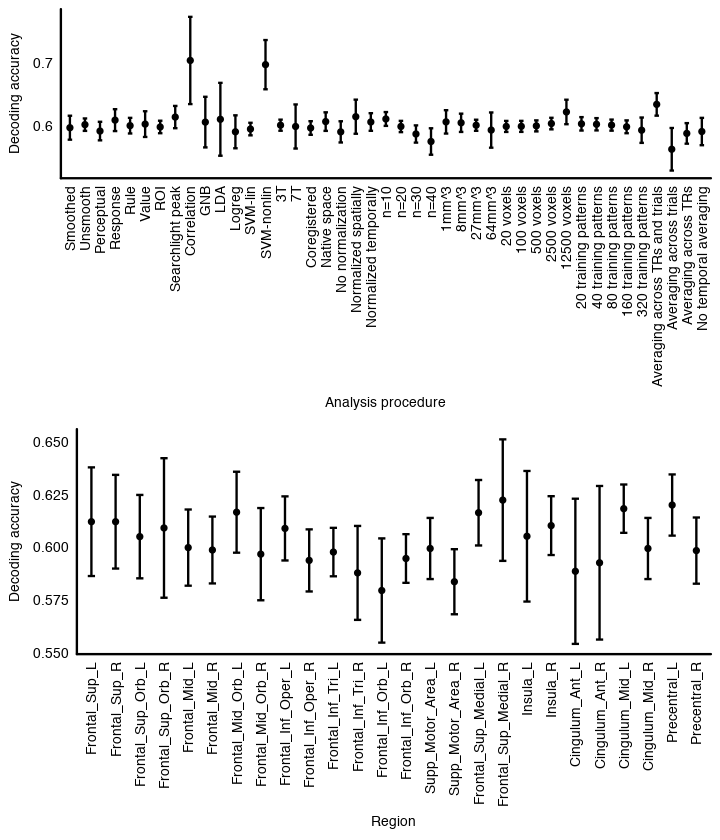

In [42]:

### Plot 

mainlinewidth=.5
textsize = 8
labelsize = 8


## Analysis Features 
p1 <-ggplot(aes(y = Accuracy, x = B,ymax = Accuracy + se, ymin=Accuracy - se), 
            data = dd_all) +
geom_point(size=1)+geom_errorbar(width=0.3)

## Regions
p10 <- ggplot(aes(y = Accuracy, x = name,ymax = Accuracy + se, ymin=Accuracy - se), 
              data = dd_region) +
geom_point(size=1)+geom_errorbar(width=0.3)

p10<-p10+scale_x_discrete(labels=rlabels)
p10<-p10+xlab('Region')
p10<-p10+ylab('Decoding accuracy')
p1<-p1+xlab('Analysis procedure')
p1<-p1+ylab('Decoding accuracy')

p1<-p1+theme(panel.background=element_blank())
p1<-p1+scale_x_discrete(labels=alabels)
p10<-p10+theme(panel.background=element_blank())


p10<-p10+theme(axis.line.x = element_line(color="black", size =mainlinewidth),
        axis.line.y = element_line(color="black", size = mainlinewidth))
p1<-p1+theme(axis.line.x = element_line(color="black", size = mainlinewidth),
        axis.line.y = element_line(color="black", size =mainlinewidth))


p10<-p10+theme(axis.text.y = element_text(size=textsize,family='Helvetica',colour='black'))
p10<-p10+theme(axis.text.x = element_text(angle = 90, hjust = 1,size=textsize,vjust=0.5,
                                          family='Helvetica',colour='black'))
p10<-p10+theme(plot.title = element_text(size=labelsize,family='Helvetica'))
p10<-p10+theme(axis.title.x = element_text(size=labelsize,family='Helvetica'))
p10<-p10+theme(axis.title.y = element_text(,size=labelsize,family='Helvetica'))

p1<-p1+theme(axis.text.y = element_text(size=textsize,family='Helvetica',colour='black'))
p1<-p1+theme(axis.text.x = element_text(angle = 90, hjust = 1,size=textsize,vjust=0.5,
                                        family='Helvetica',colour='black'))
p1<-p1+theme(plot.title = element_text(size=labelsize,family='Helvetica',colour='black'))
p1<-p1+theme(axis.title.x = element_text(size=labelsize,family='Helvetica',colour='black'))
p1<-p1+theme(axis.title.y = element_text(size=labelsize,family='Helvetica',colour='black'))


p1<-p1+theme(axis.ticks.x=element_blank(),axis.ticks.y=element_blank())
p10<-p10+theme(axis.ticks.x=element_blank(),axis.ticks.y=element_blank())

lay <- rbind(c(1),
            c(10))


#setEPS()
#postscript('../Figures/Supp_full_regression_moreregion_w_res.eps',width=6,height=7)
#grid.arrange(p1,p10 ,layout_matrix = lay)
#dev.off()

png('../Figures/Supp_full_regression_moreregions_w_extra_LR_regions.png',width=6,height=7,units="in",res=400)
#postscript('../Figures/Supp/full_regression_moreregions.eps',width=6,height=7)
grid.arrange(p1,p10 ,layout_matrix = lay)
dev.off()

options(repr.plot.width=6, repr.plot.height=7)
grid.arrange(p1,p10,layout_matrix = lay)

# Likelihood Ratio Tests 

In [43]:
data<-d

In [44]:
full_model_ml<-lme(as.formula(paste('Accuracy.50~',R1names_string,sep='')),random=~1|PID,data=d,method='ML')

full_model_wo_region<-lme(Accuracy.50~Info.type+Roi.Search+Pattern.type+Classifier.type+Scanner+
                Smoothing+Coregistration+Pattern.normalization.type+Num_subs,random=~1|PID,data=d,method='ML')


full_model_wo_Classifier.type<-update(full_model_ml,.~. -Classifier.type)
full_model_wo_Info.type<-update(full_model_ml,.~. -Info.type)
full_model_wo_Smoothing<-update(full_model_ml,.~. -Smoothing)
full_model_wo_Coregistration<-update(full_model_ml,.~. -Coregistration)
full_model_wo_Pattern.normalization.type<-update(full_model_ml,.~. -Pattern.normalization.type)
full_model_wo_Num_subs<-update(full_model_ml,.~. -Num_subs)
full_model_wo_Res<-update(full_model_ml,.~. -Resolution_Volume)

full_model_wo_VN<-update(full_model_ml,.~. -Voxel.numbers)
full_model_wo_TrainPats<-update(full_model_ml,.~. -Training.setsize)

full_model_wo_Scanner<-update(full_model_ml,.~. -Scanner)
full_model_wo_Pattern.type<-update(full_model_ml,.~. -Pattern.type)
full_model_wo_ROI<-update(full_model_ml,.~. -Roi.Search)

a <-anova(full_model_ml,full_model_wo_Classifier.type)
d<-data.frame(a)[c('Model','df','AIC','BIC','logLik','L.Ratio','p.value')]
a <-anova(full_model_ml,full_model_wo_Info.type)
d_new<-data.frame(a)[c('Model','df','AIC','BIC','logLik','L.Ratio','p.value')]
d<-rbind(d,d_new[2,])
a <-anova(full_model_ml,full_model_wo_Smoothing)
d_new<-data.frame(a)[c('Model','df','AIC','BIC','logLik','L.Ratio','p.value')]
d<-rbind(d,d_new[2,])
a <-anova(full_model_ml,full_model_wo_Coregistration)
d_new<-data.frame(a)[c('Model','df','AIC','BIC','logLik','L.Ratio','p.value')]
d<-rbind(d,d_new[2,])
a <-anova(full_model_ml,full_model_wo_Pattern.normalization.type)
d_new<-data.frame(a)[c('Model','df','AIC','BIC','logLik','L.Ratio','p.value')]
d<-rbind(d,d_new[2,])
a <-anova(full_model_ml,full_model_wo_Num_subs)
d_new<-data.frame(a)[c('Model','df','AIC','BIC','logLik','L.Ratio','p.value')]
d<-rbind(d,d_new[2,])
a <-anova(full_model_ml,full_model_wo_Scanner)
d_new<-data.frame(a)[c('Model','df','AIC','BIC','logLik','L.Ratio','p.value')]
d<-rbind(d,d_new[2,])
a <-anova(full_model_ml,full_model_wo_Pattern.type)
d_new<-data.frame(a)[c('Model','df','AIC','BIC','logLik','L.Ratio','p.value')]
d<-rbind(d,d_new[2,])
a <-anova(full_model_ml,full_model_wo_ROI)
d_new<-data.frame(a)[c('Model','df','AIC','BIC','logLik','L.Ratio','p.value')]
d<-rbind(d,d_new[2,])
a <-anova(full_model_ml,full_model_wo_region)
d_new<-data.frame(a)[c('Model','df','AIC','BIC','logLik','L.Ratio','p.value')]
d<-rbind(d,d_new[2,])
a <-anova(full_model_ml,full_model_wo_Res)
d_new<-data.frame(a)[c('Model','df','AIC','BIC','logLik','L.Ratio','p.value')]
d<-rbind(d,d_new[2,])
a <-anova(full_model_ml,full_model_wo_VN)
d_new<-data.frame(a)[c('Model','df','AIC','BIC','logLik','L.Ratio','p.value')]
d<-rbind(d,d_new[2,])
a <-anova(full_model_ml,full_model_wo_TrainPats)
d_new<-data.frame(a)[c('Model','df','AIC','BIC','logLik','L.Ratio','p.value')]
d<-rbind(d,d_new[2,])



In [45]:
d$p.value<-round(d$p.value,3)
d$AIC<-round(d$AIC,1)
d$BIC<-round(d$BIC,1)
d$logLik<-round(d$logLik,1)
d$L.Ratio<-round(d$L.Ratio,2)
d

,Model,df,AIC,BIC,logLik,L.Ratio,p.value
full_model_ml,1,49,-1378.3,-1170.6,738.2,NA,NA
full_model_wo_Classifier.type,2,44,-1377.0,-1190.5,732.5,11.27,0.046
full_model_wo_Info.type,2,46,-1383.5,-1188.5,737.7,0.85,0.837
full_model_wo_Smoothing,2,48,-1380.2,-1176.8,738.1,0.07,0.787
full_model_wo_Coregistration,2,48,-1379.8,-1176.4,737.9,0.47,0.493
full_model_wo_Pattern.normalization.type,2,47,-1381.5,-1182.2,737.7,0.85,0.654
full_model_wo_Num_subs,2,48,-1377.6,-1174.2,736.8,2.68,0.102
full_model_wo_Scanner,2,48,-1380.3,-1176.9,738.1,0.00,0.954
full_model_wo_Pattern.type,2,46,-1375.6,-1180.6,733.8,8.71,0.033
full_model_wo_ROI,2,48,-1379.7,-1176.3,737.8,0.61,0.435


Classifier and pattern type are still significant. The ROI is not. So, this generally supports the other analysis where I've excluded classifications attributable to more than one ROI. 